In [823]:
using DataFrames, CSV, CategoricalArrays
using Statistics, Clustering, LinearAlgebra
using Plots

# Student Performancing

In [768]:
filename = "./datasets/student-mat.csv"
df0 = DataFrame(CSV.File(filename))
df0[1:5,:]

5×33 DataFrame
 Row │ school   sex      age    address  famsize  Pstatus  Medu   Fedu   Mjob  ⋯
     │ String3  String1  Int64  String1  String3  String1  Int64  Int64  Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ GP       F           18  U        GT3      A            4      4  at_ho ⋯
   2 │ GP       F           17  U        GT3      T            1      1  at_ho
   3 │ GP       F           15  U        LE3      T            1      1  at_ho
   4 │ GP       F           15  U        GT3      T            4      2  healt
   5 │ GP       F           16  U        GT3      T            3      3  other ⋯
                                                              25 columns omitted

In [10]:
grades = df0[[:G1, :G2, :G3]]
head(grades)

6×3 DataFrame
│ Row │ G1    │ G2    │ G3    │
│     │ Int64 │ Int64 │ Int64 │
├─────┼───────┼───────┼───────┤
│ 1   │ 5     │ 6     │ 6     │
│ 2   │ 5     │ 5     │ 6     │
│ 3   │ 7     │ 8     │ 10    │
│ 4   │ 15    │ 14    │ 15    │
│ 5   │ 6     │ 10    │ 10    │
│ 6   │ 15    │ 15    │ 15    │

#  California Housing

In [126]:
filename = "./datasets/housing.csv"
chdata = DataFrame(CSV.File(filename))
df = copy(chdata)


dropmissing!(df)

ndf = names(df)

10-element Vector{String}:
 "longitude"
 "latitude"
 "housing_median_age"
 "total_rooms"
 "total_bedrooms"
 "population"
 "households"
 "median_income"
 "median_house_value"
 "ocean_proximity"

## Data Preprocess


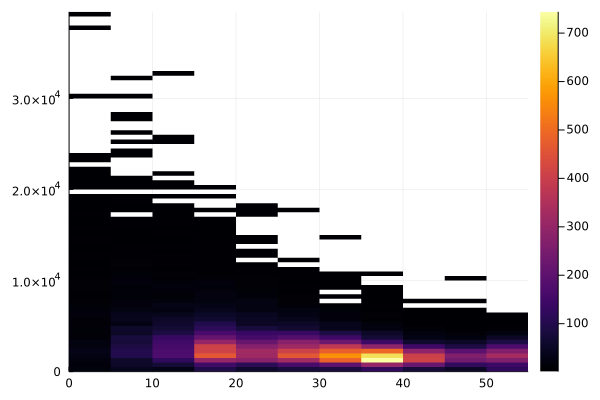

In [128]:
pos = df[!, ndf[1:2]]
pos = Array(pos)
km_pos = kmeans(pos |> transpose, 2)
df[!, "pos"] = km_pos.assignments


# scatter(pos[:,1], pos[:,2])
# scatter!(km_pos.centers[1,:], km_pos.centers[2,:])

dfop = CategoricalArray(df[!, "ocean_proximity"])
levels!(dfop, ["<1H OCEAN", "INLAND", "NEAR BAY", "NEAR OCEAN", "ISLAND"])
dfop |> levels

df[!, :lv_op] = levelcode.(dfop)
ndf = names(df)

sum(df[!, :lv_op] .== 1)

df= df[df[!, :lv_op] .!= 5, :]

name_of_y = :median_house_value
names_of_x = Symbol.(ndf[3:8])
names_of_z = Symbol.(ndf[11 : end])
dfy = df[!, name_of_y]
dfX = df[!, names_of_x]
dfZ = df[!, names_of_z]
# dfZ[1:5,:]

sample = [dfX dfZ]
sample[:y] = df[:, name_of_y]
# names(sample)

histogram2d(dfX[:,1], dfX[:,2])

20057


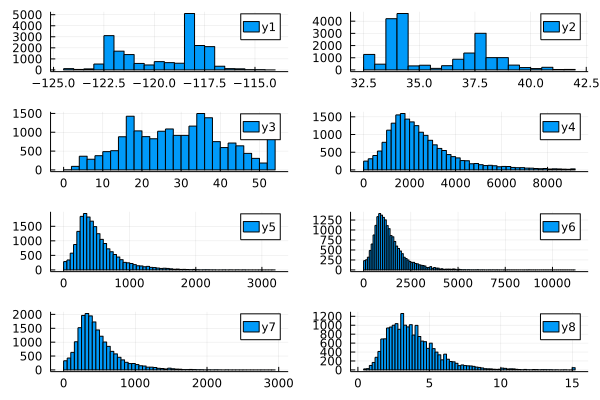

In [133]:
mx = mean(X, dims = 1)

sx = std(X, dims = 1)

up_x = mx .+  3 * sx

ind = Bool.(ones(n))
for k in 1:n
ind[k] =  X[k, 4:7] < up_x[4:7]
end

println(sum(ind))

# X = scaler(X, 2)
X_ = X[ind, :]
figx = plot(layout = (4,2))
for k in 1:8
    pk = figx.subplots[k]
    histogram!(pk, X_[:, k])
end
    figx
    

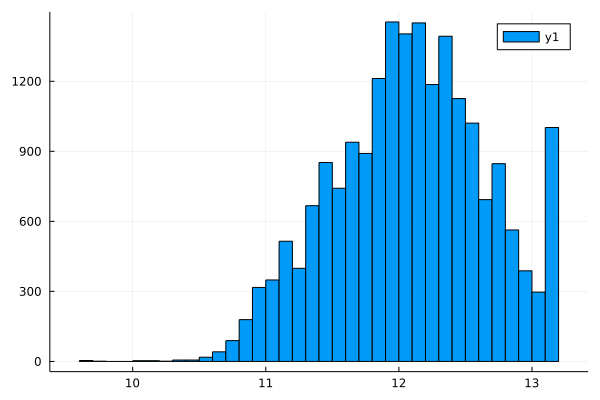

In [136]:
histogram(y[ind])

## GLM fitting

In [744]:
using GLM, QuantReg

┌ Info: Precompiling QuantReg [a0becc08-653f-40d2-91e7-721373d1053f]
└ @ Base loading.jl:1342
┌ Warning: Module DataFrames with build ID 1366377198511 is missing from the cache.
│ This may mean DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing QuantReg [a0becc08-653f-40d2-91e7-721373d1053f].
└ @ Base loading.jl:1047
┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1342
┌ Warning: Module ForwardDiff with build ID 1367428348610 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing JuMP [4076af6c-e467-56ae-b986-b466b2749572].
└ @ Base loading.jl:1047


In [745]:
formula = Term(name_of_y) ~ sum([Term(x) for x in names_of_x])

FormulaTerm
Response:
  median_house_value(unknown)
Predictors:
  housing_median_age(unknown)
  total_rooms(unknown)
  total_bedrooms(unknown)
  population(unknown)
  households(unknown)
  median_income(unknown)

In [101]:
model = lm(formula, df[1:2000,:])

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

median_house_value ~ 1 + housing_median_age + total_rooms + total_bedrooms + population + households + median_income

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -24763.6      5721.25     -4.33    <1e-04  -35983.9      -13543.4
housing_median_age    1206.56       98.1291   12.30    <1e-32    1014.11       1399.01
total_rooms              0.56757     2.35607   0.24    0.8097      -4.05305       5.18819
total_bedrooms          13.1151     22.4963    0.58    0.5600     -31.0037       57.2339
population             -35.7155      4.34982  -8.21    <1e-15     -4

In [60]:
cor(y, X[:,4])

0.18102224239954584

## QGPLSIM fitting

In [371]:
include("supportFunctions.ji")
include("qgplsim.ji")
include("get_califdata.ji")
using ProgressBars


In [324]:

Xa, Za, ya = califdata(30.0) # a for all

size(Xa)

(20428, 8)

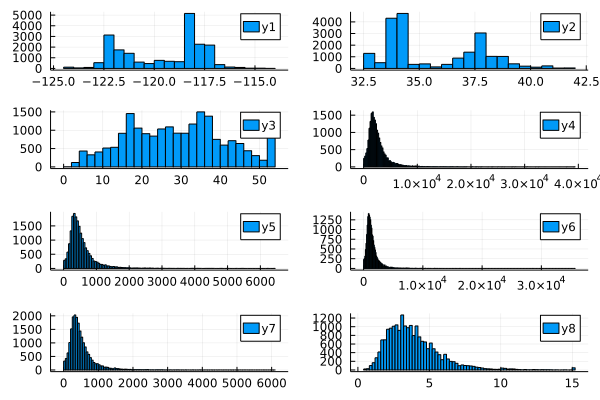

In [325]:
# X = scaler(X, 2)
using Plots
figx = plot(layout = (4,2))
for k in 1:8
    pk = figx.subplots[k]
    histogram!(pk, Xa[:, k])
end
    figx

In [372]:
nmc = 40
mse = zeros(nmc)
t = 1
X = scaler(Xa, 1)[:,[3,4,6,7,8]]
y = log.(ya)

Z = categ_binary(Za)
categ, index = collection(Z)
# Z = Z[:, 1]
n,p = size(X)  
n,q = size(Z)
ncateg = q + 1

prop = zeros(q + 1)
prop[1:q] = sum(Z, dims = 1) ./ n
prop[q + 1] = 1 - sum(prop)

ntrain = 2000
ntest = 10000
Theta = zeros(nmc, p)
Gamma = zeros(nmc, q)
Alpha = zeros(nmc, p)
Beta  = zeros(nmc, q)

width_exp = -0.01
tau = [0.5]
# tau = [0.25, 0.5, 0.75]
each_ntrain = Int.(round.(ntrain .* prop))
# @threads for t in tqdm(1:nmc)

    indn = Array(1:n)
    indr = []
    for k in 1:ncateg
        zk = categ[k]
        indr = [indr; rand(index[zk], each_ntrain[k])]
    end

    indt = [x in indr for x in indn]
    indt = Bool.(1 .- indt)
    indt = rand(indn[indt], ntest)

    Xr = X[indr, :]
    yr = y[indr] 
    Zr = Z[indr, :]

    Xt = X[indt, :]
    yt = y[indt]  
    Zt = Z[indt, :]
    # categ, index = collection(Z)
    # for zk in categ
    #  println(zk, " ", length(index[zk]))
    # end
    # train_data = [Xr Zr yr]
    # histogram(train_data[:,6])
    # var(train_data, dims = 1)[1:6]

    qsmodel = qgplsim.model(Xr, Zr, yr, tau, width_exp)
    # for zk in qsmodel.categ
    #  println(zk, " ", length(qsmodel.index[zk]))
    # end

    # qsmodel1 = qgplsim.model(Xr, Zr, yr, 0.1)
    # qsmodel9 = qgplsim.model(Xr, Zr, yr, 0.9)
    # @time qgplsim.estimator(qsmodel1)
    # @time qgplsim.estimator(qsmodel9)

    Theta[t, :], Gamma[t, :],
    Alpha[t, :], Beta[t, :] = qgplsim.estimator(qsmodel)

    vv = Xt * qsmodel.alpha
    ylx = Xt * qsmodel.theta
    ylz = Zt * qsmodel.beta
    yp = qgplsim.predict(qsmodel, Xt, Zt) + ylx # + ylz
    ## yp .= (abs.(yp) .> 1e2) .* 0 + (abs.(yp) .<= 1e2) .* yp
    bias = yt - yp
    res = sum(bias.^2) / ntest
    # println(res)
    mse[t] = res
# end

0.13223011970707874

In [340]:
    # vvr = Xr * qsmodel.alpha
    # ylxr = Xr * qsmodel.theta
    # ylzr = Zr * qsmodel.beta
    # ypr = qgplsim.predict(qsmodel, Xr, Zr) + ylxr # + ylz
    # ## yp .= (abs.(yp) .> 1e2) .* 0 + (abs.(yp) .<= 1e2) .* yp
    # bias = yr - ypr
    # resr = sum(bias.^2) / ntrain
    # # println(res)
    # mse[2] = resr

In [381]:
mse

100-element Vector{Float64}:
 0.15519202530032317
 0.17408756003733722
 0.14533696808626848
 0.12531634166034442
 0.6838974634036249
 0.12337081363903071
 0.14839855495822923
 0.14064864626372
 0.15403745997795537
 0.116091967101564
 0.13327699295438086
 0.49596920676345047
 0.14023711401458805
 ⋮
 0.17069710990140333
 0.1481726327483922
 0.1749996453842206
 0.14620359363300503
 0.6384548053015792
 0.716729535364023
 0.1217454197643388
 0.5490882178965419
 0.12280527514683368
 0.6787990776487473
 0.14699335372692676
 0.14204697129709076

In [382]:
mean(mse)

0.27716422767653204

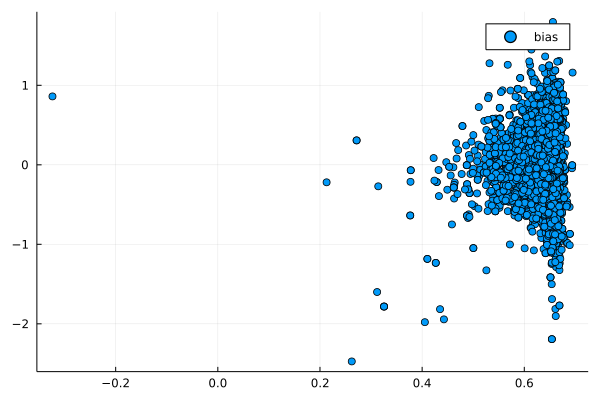

In [373]:
using Plots
scatter(vv, yt - yp, label = "bias")
# scatter!(vv, yp .- ylx, color = "red", label = "y_nonlinear")
# scatter!(vv, yp,  label = "y_predict")
# scatter!(vv, ylx, label = "y_linear")


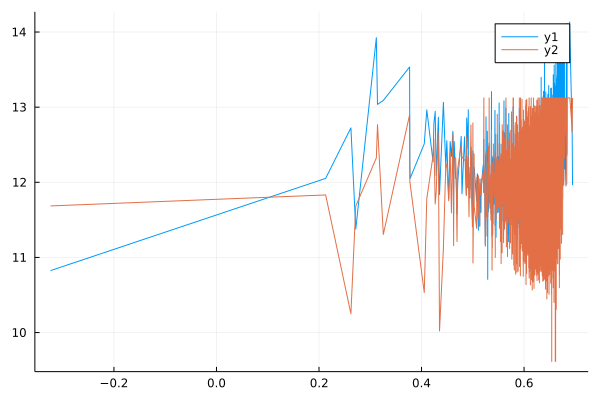

In [374]:
indp = sortperm(vv)
plot(vv[indp], yp[indp])
plot!(vv[indp], yt[indp])


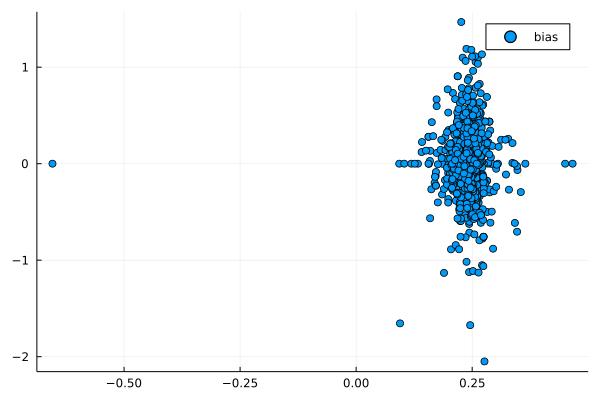

In [352]:
using Plots
scatter(vvr, yr - ypr, label = "bias")
# scatter!(vvr, ypr .- ylxr, color = "red", label = "y_nonlinear")
# scatter!(vvr, ypr,  label = "y_predict")
# scatter!(vvr, ylxr, label = "y_linear")

In [368]:
std(vv)

0.03576952535366804

In [369]:
mean(vv)

-0.7008136976133071

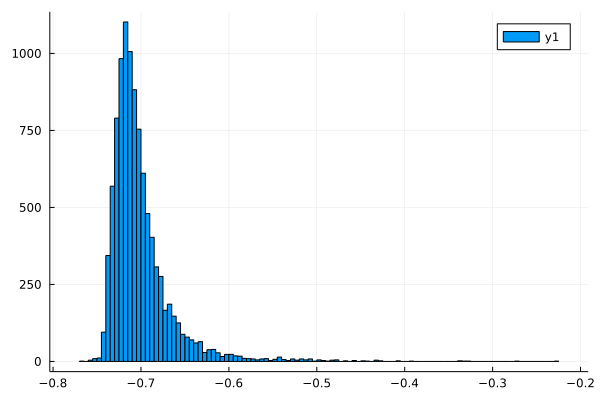

In [366]:

histogram(vv)

In [367]:
fig = plot(layouts = (4,2))
categ, index = collection(Zt)
for k in 1:7
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    vk = vv[indk]
    ypk = yp[indk]
    # yp1k = yp1[indk]
    # yp9k = yp9[indk]
    ytk = yt[indk]
    scatter!(pk, vk, ytk, label = false)
    scatter!(pk, vk, ypk, label = false)
    # scatter!(pk, vk, yp1k, label = false)
    # scatter!(pk, vk, yp9k, label = false)
end
fig

In [337]:
g = zeros(ntest)
dg = zeros(ntest)
yz = yt - ylx
τ = tau
v = vv
categ, index = collection(Zt)
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

# max_v = maximum(v)
# min_v = minimum(v)
# widv =   max_v - min_v    
# v = ((v .- min_v) / widv .- 0.5) * 4

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(width_exp) * std(vk)   
    # println(h)
    width[k] = h 

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ, width_exp)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ, width_exp)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) # + h
    vkmax = maximum(vk) # - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

mh = minimum(width)
v0 = v0 + 1*mh
v1 = v1 - 1*mh


v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)

dgf (generic function with 1 method)

[25.71953683741717, -13.742430454457978]
[0.17933588313937218, 0.3400604715619683]


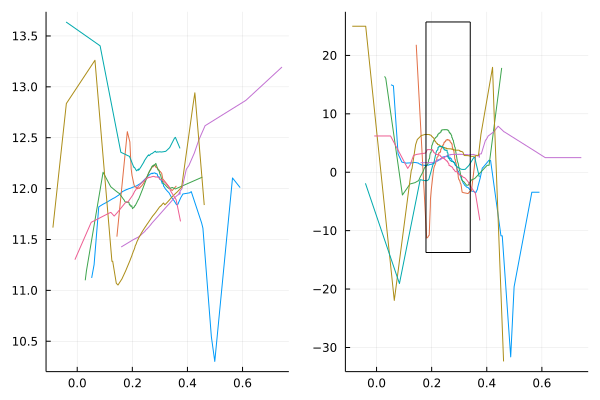

In [338]:
p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = false ) # L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false ) # L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1) # minimum(C1[C1 .> c0])
println("[$c0, $c1]")
println("[$v0, $v1]")

plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [320]:
C0

7-element Vector{Float64}:
 -4.730098566078558
 -4.426710500622263
 -7.813672893281875
 -4.619390211169813
 -2.418795155675887
 -5.771987074957818
 -8.05533723646019